# Calibration of the Chaboche mecanical model

## Deterministic model

The Chaboche mecanical law predicts the stress depending on the strain:
$$
\sigma = G(\epsilon,R,C,\gamma) = R + \frac{C}{\gamma} (1-\exp(-\gamma\epsilon))
$$
where 

- $\epsilon$ is the strain,
- $\sigma$ is the stress (Pa),
- $R$, $C$, $\gamma$ are the parameters.

The variables have the following distributions and are supposed to be independent.

| Random var. | Distribution | 
|--|--|
| $R$ | Lognormal ($\mu = 750$ MPa, $\sigma = 11$) |
| $C$ | Normal ($\mu = 2750$ MPa, $\sigma = 250$) |
| $\gamma$ | Normal ($\mu = 10$, $\sigma = 2$) |
| $\epsilon$ | Uniform(a=0, b=0.07). |

## Parameters to calibrate

The vector of parameters to calibrate is: 
$$
\theta = (R,C,\gamma).
$$
We set :

- $R = 750\times 10^6$,
- $C = 2750\times 10^6$,
- $\gamma = 10$.

## Observations

In order to create a calibration problem, we make the hypothesis that the strain has the following distribution:
$$
\epsilon \sim Uniform(0,0.07).
$$

Moreover, we consider a gaussian noise on the observed constraint:
$$
\epsilon_\sigma \sim \mathcal{N} \left(0,40\times 10^6\right)
$$
and we make the hypothesis that the observation errors are independent.
We set the number of observations to:
$$
n = 100.
$$
We generate a Monte-Carlo samplg with size $n$:
$$
\sigma_i = G(\epsilon_i,R,C,\gamma) + (\epsilon_\sigma)_i, 
$$
for $i = 1,..., n$.
The observations are the pairs $\{(\epsilon_i,\sigma_i)\}_{i=1,...,n}$, i.e. each observation is a couple made of the strain and the corresponding stress.

## Thanks to

- Antoine Dumas, Phimeca


## References

- J. Lemaitre and J. L. Chaboche (2002) "Mechanics of solid materials" Cambridge University Press.

## Generate the observations

In [1]:
import numpy as np
import openturns as ot

Define the model.

In [2]:
def modelChaboche(X):
    strain,R,C,gamma = X
    stress = R + C*(1-np.exp(-gamma*strain))
    return [stress]

Create the Python function.

In [3]:
g = ot.PythonFunction(4, 1, modelChaboche) 

Define the random vector.

In [4]:
Strain = ot.Uniform(0,0.07)
unknownR = 750e6
unknownC = 2750e6
unknownGamma = 10
R = ot.Dirac(unknownR)
C = ot.Dirac(unknownC)
Gamma = ot.Dirac(unknownGamma)

Strain.setDescription(["Strain"])
R.setDescription(["R"])
C.setDescription(["C"])
Gamma.setDescription(["Gamma"])

Create the joint input distribution function.

In [5]:
inputRandomVector = ot.ComposedDistribution([Strain, R, C, Gamma])

Create the Monte-Carlo sample.

In [6]:
sampleSize = 100
inputSample = inputRandomVector.getSample(sampleSize)
outputStress = g(inputSample)
outputStress[0:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[y0] data=[[1.73052e+09],[2.01764e+09],[9.98458e+08],[8.11861e+08],[1.34312e+09]]

Plot the histogram of the output.

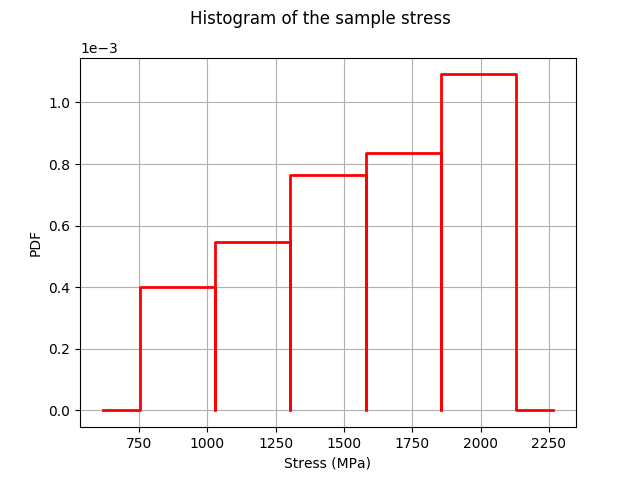

In [7]:
histoGraph = ot.HistogramFactory().build(outputStress/1.e6).drawPDF()
histoGraph.setTitle("Histogram of the sample stress")
histoGraph.setXTitle("Stress (MPa)")
histoGraph.setLegends([""])
histoGraph

Generate observation noise.

In [8]:
stressObservationNoiseSigma = 40.e6 # (Pa)
noiseSigma = ot.Normal(0.,stressObservationNoiseSigma)
sampleNoiseH = noiseSigma.getSample(sampleSize)
observedStress = outputStress + sampleNoiseH

In [9]:
observedStrain = inputSample[:,0]

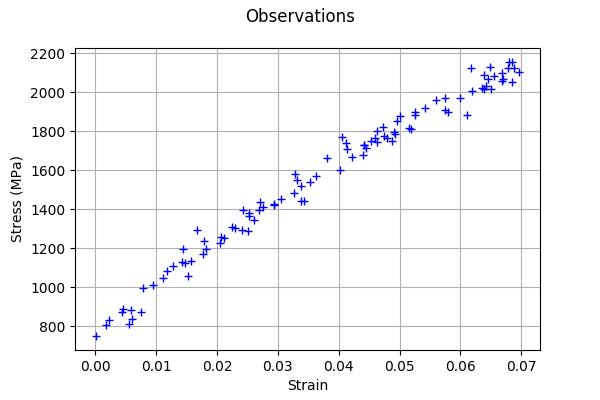

In [10]:
graph = ot.Graph("Observations","Strain","Stress (MPa)",True)
cloud = ot.Cloud(observedStrain,observedStress/1.e6)
graph.add(cloud)
graph

## Calibration with non linear least squares

In [11]:
# Parametres
R = 750e6 # Exact : 750e6
C = 2700e6 # Exact : 2750e6
Gamma = 8. # Exact : 10
candidate = [R,C,Gamma]

In [12]:
calibratedIndices = [1,2,3]
calibrationFunc = ot.ParametricFunction(g, calibratedIndices, candidate)

In [13]:
stressPredictedBefore = calibrationFunc(observedStrain)
stressPredictedBefore[0:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[y0] data=[[1.55253e+09],[1.80312e+09],[9.46982e+08],[7.987e+08],[1.22691e+09]]

In [14]:
def costFunction(theta):
    '''Calibration cost function'''
    # Compute residuals
    calibrationFunc.setParameter(theta)
    stressPredicted = calibrationFunc(observedStrain)
    r = observedStress.asPoint() - stressPredicted.asPoint()
    # Perform the sum of squares
    sumOfSquares = r.normSquare()**2
    return [sumOfSquares]

In [15]:
costFunction(candidate)

[7.090767210622178e+36]

In [16]:
objective = ot.PythonFunction(len(candidate), 1, costFunction)

Define the problem bounds.

In [17]:
boundsMin = [600e6,2000e6,7.]
boundsMax = [800e6,3000e6,12.]

In [18]:
bounds = ot.Interval(boundsMin,boundsMax)
# define the problem
problem = ot.OptimizationProblem(objective)
problem.setMinimization(True)
problem.setBounds(bounds)

labelsTheta = ("R","C","Gamma")

Solves the non linear least squares problem.

In [19]:
maximumIteration = 1000
algo = ot.Cobyla()
algo.setProblem(problem)
algo.setMaximumIterationNumber(maximumIteration)
algo.setStartingPoint(candidate)
# Run !
algo.run()

Get the results.

In [20]:
result = algo.getResult()
thetaStar = result.getOptimalPoint()
thetaStar

class=Point name=Unnamed dimension=3 values=[7.5e+08,2.7e+09,10.1796]

Get the number of function evaluations

In [21]:
nfeval = objective.getEvaluationCallsNumber()
nfeval

70

In [22]:
costFunction(thetaStar)

[3.7267458380975037e+34]

In [23]:
calibrationFunc.setParameter(thetaStar)
stressPredictedAfter = calibrationFunc(observedStrain)

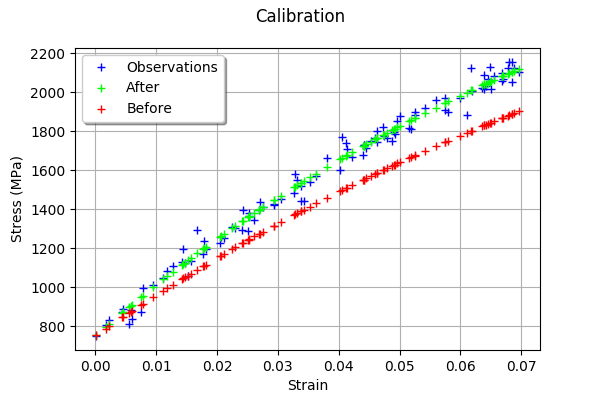

In [24]:
graph = ot.Graph("Calibration","Strain","Stress (MPa)",True)
cloud = ot.Cloud(observedStrain,observedStress/1.e6)
cloud.setLegend("Observations")
graph.add(cloud)
cloud = ot.Cloud(observedStrain,stressPredictedAfter/1.e6)
cloud.setLegend("After")
cloud.setColor("green")
graph.add(cloud)
cloud = ot.Cloud(observedStrain,stressPredictedBefore/1.e6)
cloud.setLegend("Before")
cloud.setColor("red")
graph.add(cloud)
graph.setLegendPosition("topleft")
graph

## Conclusion

There are various other ways this example could be performed. 
* The `LeastSquaresProblem` class is designed specifically for solving non linear least squares problems.
* The `NonLinearLeastSquaresCalibration` class is designed to solve non linear least squares calibration problems.